# Домашнее задание №1

В данном задании вам предлагаются 3 задачи:
#### 1. Бинарная классификация изображений кошек и собак  (0.4 балла)
Вам потребуется обучить свёрточную нейронную сеть для классификации изображений кошек и собак. Для решения задачи вы зададите архитектуру сети, определите оптимайзер и функцию потерь.  
**Ваша цель:** используя известные вам слои, собрать сеть, дающую $>75\%$ точности классификации на тесте. При обученни нейросети, можете пользоваться вспомогательными функциями *train_model* и *test_model*
#### 2. Обучение классических [ResNet-50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) моделей на наборе данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) (0.6 баллов)
В этой задаче вам необходимо обучить несколько моделей ResNet-50 для решения задачи классификации.  
**Ваша цель:** Обучить ResNet-50 "с нуля" на CIFAR-10, инициировав веса модели случаными значениями. Затем провести сравнение обучения на CIFAR-10 предобученной модели и модели, обучаемой с нуля.  
Есть гипотеза, что предобучение на больших наборах данных, таких как [ImageNet](https://www.image-net.org/), помогает при решение других задач, например классификации на малом наборе данных (см. [Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)). Веса предобученной модели содержат некую информацию о встречающихся в природе изображениях, и эта информация может быть использована при решение задач на малом наборе данных. Сравните точности классификации предобученной ResNet-50 модели с моделью обучаемой с нуля. Обучение моделей проведите на подвыборках обучающей выборки CIFAR-10. Возьмите, например, выборку 1%, 10%, 50%, 80% от размера исходной и нарисуйте зависимость точности моделей на тесте от размера обучающей выборки.
#### 3. Поиск точек схода прямых (Vanishing Points)  (0.6 баллов)
В данной задаче вам предстоит использовать детекторы отрезков на изображении для поиска точки схода прямых ([Постановска задачи](https://arxiv.org/pdf/1608.04267.pdf)). Вам будет предложен набор изображений, на которых присутствует ровно одна точка схождения прямых. С помощью детектора отрезков вы можете найти отрезки на изображении. По имеющимся отрезкам можно вычислить точку их пересечения, которая и будет ответом задачи.   
**Ваша цель:** Найти точки схода прямых с помощью детектора отрезков на представленных изображениях.  
Дополнительные баллы (0.2 балла) будут даваться за качественное сравнение (визуально) нейросетевых детекторов отрезков, например [LSDNet](https://github.com/iitpvisionlab/LSDNet), и классических [Hough Transform](https://en.wikipedia.org/wiki/Hough_transform), [LSD: a Line Segment Detector](http://www.ipol.im/pub/art/2012/gjmr-lsd/article.pdf).  
Критерий нахождения точки схода визуальный: нарисуйте найденную вами точку красным, а точку из разметки зелёным. 
Ваш метод должен найти точки схода прямых на как можно большем числе изображений. Дополнительные бонусные баллы получат решения, которые правильно находят точки схода на большем числе изображений.  
Также вы можете попробовать обучить сеть, предсказывающую точки схода напрямую. Возможный подход для обучения модели будет изложен в описании задачи. 


## Задача 1. Бинарная классификация изображений (0.4 балла)
<img src="https://www.researchgate.net/profile/Atul-Sharma-77/publication/353247632/figure/fig2/AS:1045582240026626@1626297640509/Classification-of-two-classes-dog-and-cat-using-CNN_W640.jpg" alt="drawing" width="700">  


Вам предлагается обучить свёрточную нейронную сеть для решения задачи бинарной классификации изображений кошек и собак.  
Обучить параметры сети вы можете с помощью градиентного спуска, описанного на лекциях.  
Ниже дан вспомогательный код для загрузки изображений и для обучения модели.

In [4]:
import os

from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
from pathlib import Path
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchsummary import summary

In [ ]:
# Запускать только если вы работаете в google collab

from google.colab import drive
drive.mount('/content/drive')

## 

In [2]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = 'data' # PATH TO THE DATASET

# Number of threads for data loader
NUM_WORKERS = 4

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 96
N_CHANNELS = 3

# Number of classes in the dataset
NUM_CLASSES = 2

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 128

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 256

In [3]:
# используем GPU при наличии
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

### Загрузка данных

In [ ]:
!wget -nc https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
!unzip -n data.zip -d data
!rm data.zip

### Определение преобразований, применяемых к изображениям

In [4]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train_11k'), transform=transformer)
val_dataset   = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer)
test_dataset  = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'test_labeled'), transform=transformer)

n_train, n_val, n_test = len(train_dataset), len(val_dataset), len(test_dataset)

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

### Функция обучения нейронной сети

In [8]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            opt.step()
            train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in val_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # compute logits
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = np.mean(val_accuracy[-n_val // BATCH_SIZE :]) * 100
        
        print(f"  training loss (in-iteration): \t{train_loss_value:.6f}")
        print(f"  validation accuracy: \t\t\t{val_accuracy_value:.2f} %")

    return train_loss, val_accuracy

## Определение и обучение нейронной сети

### First step

**conv-pool-conv-pool-dense-dense!**

Создайте мини-сверточную нейронную сеть со следующей структурой:
* Входной слой
* 3 классических сверточных блока `convolution->relu->pool`: 
  * свертка 3x3 с 128 фильтрами и функцией активации _ReLU_
  * 2x2 пулинг (или поставьте для предыдущей свертки страйд = 3)
 * Flatten
* 30% Dropout 
* Линейный слой с 256 нейронами и функцией активации _ReLU_
* 30% dropout
* Выходной линейный слой.

Вы также можете добавить [BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) слой, который может значительно увеличить скорость сходимости модели

__Convolutional layers__ в торче создаются как любой другой слой, но у него есть особые параметры:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)) # свёртка`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2 на 2`__

__`...`__


Когда вы закончите создание нейросети, обучите её с оптимайзером __Adam__ с LR = 3e-4 (Константа Карпатого)

Если всё верно, вы должны получить минимум __75%__ точности на валидации.

Количество каналов должно быть в порядке количества class_labels

Вы можете поставить stride=2 для Conv2d слоя чтобы увеличить скорость обучения, но помните про размерности

In [30]:
model_cnn = nn.Sequential()



model_cnn.add_module('conv1', nn.Conv2d(3, 64, 3, stride=2))
# Место для вашего кода: CONV->POOL->CONV-POOL->... as many as you wish






# End of your code here
# global average pooling
model_cnn.add_module('gap_5', nn.AdaptiveAvgPool2d((2, 2)))
# dropout for regularization
model_cnn.add_module('dropout_5', nn.Dropout(0.3))
# "flatten" the data
model_cnn.add_module('flat', Flatten())
# last fully-connected layer, used to create embedding vectors
model_cnn.add_module('fc_6', nn.Linear(128, EMBEDDING_SIZE))
model_cnn.add_module('relu_6', nn.ReLU())

model_cnn.add_module('dropout_6', nn.Dropout(0.3))

# logits for NUM_CLASSES=2 classes
model_cnn.add_module('fc_logits', nn.Linear(EMBEDDING_SIZE, NUM_CLASSES))
model_cnn.add_module('fc_preds', nn.Sigmoid())

# move model to computing device
model_cnn = model_cnn.to(device)

In [31]:
train_dataset[0][0].shape

torch.Size([3, 96, 96])

In [32]:
model_cnn

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (gap_5): AdaptiveAvgPool2d(output_size=(2, 2))
  (dropout_5): Dropout(p=0.3, inplace=False)
  (flat): Flatten()
  (fc_6): Linear(in_features=128, out_features=256, bias=True)
  (relu_6): ReLU()
  (dropout_6): Dropout(p=0.3, inplace=False)
  (fc_logits): Linear(in_features=256, out_features=2, bias=True)
  (fc_preds): Sigmoid()
)

In [33]:
summary(model_cnn, train_dataset[0][0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 47, 47]           1,792
            Conv2d-2           [-1, 64, 23, 23]          36,928
            Conv2d-3           [-1, 32, 11, 11]          18,464
 AdaptiveAvgPool2d-4             [-1, 32, 2, 2]               0
           Dropout-5             [-1, 32, 2, 2]               0
           Flatten-6                  [-1, 128]               0
            Linear-7                  [-1, 256]          33,024
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                    [-1, 2]             514
          Sigmoid-11                    [-1, 2]               0
Total params: 90,722
Trainable params: 90,722
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/ba

In [36]:
#Оптимайзер
opt = ??

#Функция потерь (Лосс функция)
loss_fn = ??

#Число эпох
n_epochs =  ??

In [37]:
opt.zero_grad()
train_loss, val_accuracy = train_model(model_cnn,
                                         train_loader,
                                         val_loader,
                                         loss_fn,
                                         opt,
                                         n_epochs)

Epoch 1 of 1 took 28.429s
  training loss (in-iteration): 	0.692948
  validation accuracy: 			52.54 %


In [38]:
def test_model(model, test_loader, subset='test'):
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in test_loader:
        logits = model(X_batch.to(device))
        y_pred = logits.max(1)[1].data
        test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    test_accuracy = np.mean(test_batch_acc)
    
    print("Results:")
    print(f"  {subset} accuracy:\t\t{test_accuracy * 100:.2f} %")
    if test_accuracy > 0.9:
        print("Amazing!")
    elif test_accuracy > 0.7:
        print("Good!")
    else:
        print("We need more magic! Follow instructons above")
    return test_accuracy

In [40]:

val_accuracy = test_model(model_cnn, val_loader, subset='val')
test_accuracy = test_model(model_cnn, test_loader, subset='test')

Results:
  val accuracy:		52.54 %
We need more magic! Follow instructons above
Results:
  test accuracy:		53.38 %
We need more magic! Follow instructons above


## Задача 2. Классификация с помощью ResNet50 (0.6 баллов)  
<img src="https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png" alt="drawing" width="400">  

Вам предлагается обучить популярную свёрточную нейронную сеть [ResNet-50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html)  для решения задачи классификации на наборе данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).  
Выполнение задачи состоит из следующих шагов:
1. Обучение ResNet-50 на CIFAR-10 с нуля и измерение точности классификации на тестовой выборке
2. Дообучение предобученной на [ImageNet](https://www.image-net.org/) ResNet-50 (pretrained=True), сравнение точности с моделью из первого пункта
3. Исследование эффекта Transfer learning. Обучите модели из пунктов 1-2 на подвыборке обучающей выборки CIFAR-10, сохраняя тестовый набор неизменным.
Так как в весах предобученной на ImageNet модели содержится информация о натуральных избражениях, то ей достаточно меньшего обучающего набора (чем для модели, обучаемой с нуля), чтобы получить высокую точность на тесте. Проверте эту гипотезу для размеров обучающей выборки размера 1%, 10%, 50%, 80% от размера исходной. Нарисуйте график, где по оси X отложен размер обучающей выборки, а по оси Y точность на тесте предобученной модели и обученной с нуля. Помогает ли предобучение модели?

### Загрузка данных

In [3]:
def get_transform(train):
    if train:
        transform = transforms.Compose(
            [
                transforms.Resize((32, 32)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
                ),
            ]
        )
    else:
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
                ),
            ]
        )
    return transform
DATA_PATH = "cifar_data"


BATCH_SIZE = 128


train_dset = torchvision.datasets.CIFAR10(
    DATA_PATH,
    train=True,
    transform=get_transform(train=True),
    download=True,
)
test_dset = torchvision.datasets.CIFAR10(
    DATA_PATH,
    train=False,
    transform=get_transform(train=False),
    download=True,
)

train_loader = torch.utils.data.DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

val_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

Files already downloaded and verified
Files already downloaded and verified


### Загрузка модели

Так как разрешение изображений в наборе данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), меньше чем в на наборе данных [ImageNet](https://www.image-net.org/) (целевой набор данных для разработчиков ResNet-50), мы заменим первый свёрточный слой с ядром $(7\times 7)$ и страйдом $2$, на свёрточный слой с ядром размера $(3\times3)$ и страйдом $1$  
Также мы удалим первый maxpolling слой

In [50]:
resnet50 = torchvision.models.resnet50(pretrained=False).to(device)

new_modules = [
    nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
] + list(resnet50.children())[4:-1] + [Flatten(), nn.Sequential(nn.Linear(2048, 10))]
resnet50_cifar = torch.nn.Sequential(*new_modules).to(device)

#summary(resnet50_cifar, (3, 32, 32))

### Обучение и сравнение моделей

In [ ]:
# Место для вашего кода

## Задача 3. Поиск точек схода прямых (Vanishing Points) (0.6 баллов)

<img src="https://zihan-z.github.io/projects/vpdetection/teaser.jpg" alt="drawing" width="800">

Вам предлагается решить задачу поиска точки схода прямых с помощью детектирования отрезков. Также вы можете попробовать нейросетевой способ, где точка схода предсказывается на прямую с помощью нейросети.

#### **Способ решения задачи, основанный на детектировании отрезков:**
В данной задаче вам предстоит использовать детекторы отрезков на изображении для поиска точки схода прямых ([Постановска задачи](https://arxiv.org/pdf/1608.04267.pdf)). Вам будет предложен набор изображений, на которых присутствует ровно одна точка схождения прямых. С помощью детектора отрезков вы можете найти отрезки на изображении. По имеющимся отрезкам можно вычислить точку их пересечения, которая и будет ответом задачи.   
**Ваша цель:** Найти точки схода прямых с помощью детектора отрезков на представленных изображениях.  
Дополнительные баллы (0.2 балла) будут даваться за качественное сравнение (визуально) нейросетевых детекторов отрезков, например [LSDNet](https://github.com/iitpvisionlab/LSDNet), и классических [Hough Transform](https://en.wikipedia.org/wiki/Hough_transform), [LSD: a Line Segment Detector](http://www.ipol.im/pub/art/2012/gjmr-lsd/article.pdf).  
Критерий нахождения точки схода визуальный: нарисуйте найденную вами точку красным, а точку из разметки зелёным. 
Ваш метод должен найти точки схода прямых на как можно большем числе изображений предоставленного ниже набора *vp_images*. Дополнительные бонусные баллы получат решения, которые правильно находят точки схода на большем числе изображений.

In [ ]:
!wget -nc https://dl.dropboxusercontent.com/s/dwy2mo6jd52r5rh/vp_images.zip
!unzip vp_images.zip

import pandas as pd
vanish_points = pd.read_csv('vp_images/vanish_points.csv', sep=';')

import cv2
image_name = '1_SI'
image = cv2.imread(f'vp_images/{image_name}.png')

point = (vanish_points.iloc[0].x, vanish_points.iloc[0].y)
image = cv2.circle(image, point, radius=5, color=(255, 0, 0), thickness=-1)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB));

In [ ]:
# Место для вашего кода

#### **Нейросетевой способ решения задачи:**
Вы можете подойти к решению задачи поиска точки схода прямых с точки зрения глубокого обучения. Обучите на представленном ниже наборе данных свёрточную нейронную сеть ResNet-50 для предсказания точки пересечения напрямую. На вход нейросети подаётся изображение, на котором нужно найти точку схода. Нейросеть предсказывает 2 числа: $(x_{pred}, y_{pred})$ - коодинаты точки схода. Между предсказанными координатами и истинными координатами из разметки, $(x_{true}, y_{true})$, в процессе обучения минимизируется евклидово расстояние:
$$
L = \frac{1}{N}\sum_{i=1}^N\left[(x^i_{pred} - x^i_{true})^2 + (y^i_{pred} - y^i_{true})^2\right]
$$
где N - размер батча.

Схематично процесс предсказания представлен на рисунке. Красная точка указывает истинные координаты точки схода прямых:

<img src="https://dl.dropboxusercontent.com/s/adu1baosbrrj5ui/resnet.png?dl=0" alt="drawing" width="800">

Для обучения нейросети выполните следующие шаги:
1. Загрузите набор данных для обучения по ссылке: https://disk.yandex.ru/d/ebRGghDv-aRKMg/dataset
2. Используйте изображения в папке *semenkov* для теста, отстальные для обучения (загрузчик данных будет дан ниже)
3. Возмите нейросеть ResNet-50 и поменяйте предсказывающую голову, подобно тому, как это было сделано в Задаче 2, где была отброшена ImageNet голова (матрица размера $2028\times1000$) на CIFAR-10 голову (матрица размера $2028\times10$). Вам нужно, чтобы предсказывались 2 числа. Можете выбрать в качестве головы матрицу размера $2028\times2$
4. Используйте $L_2$ фукцию потерь для обучения модели

In [8]:
from torch.utils.data import DataLoader, Dataset
from glob import glob
import pandas as pd
from skimage import io, transform
from pathlib import Path
class VanishingPoints(Dataset):
    def __init__(self, data_dir: str, subset: str, transforms) -> None:
        super().__init__()
        self.transforms = transforms
        test_dir = 'semenkov'
        if subset == 'test':
            vanish_points = pd.read_csv(str(Path(data_dir) / test_dir / 'vanish_points.csv'), sep=';')
            vanish_points = vanish_points[vanish_points.comment!='there is no VP']
            self.image_paths = []
            self.vp_targets = []
            for row in vanish_points.values:
                self.image_paths.append(str(Path(data_dir) / test_dir/row[0]))
                self.vp_targets.append(np.array([row[1], row[2]]))
        elif subset == 'train':
            dataset_dirs = list(glob(str(Path(data_dir) / '*')))
            self.image_paths = []
            self.vp_targets = []
            for dir_path in dataset_dirs:
                if test_dir in dir_path:
                    continue
                #print(dir_path)
                csv_path = list(glob(str(Path(dir_path) / '*.csv')))[0]
                if 'sokol' not in dir_path:
                    
                    vanish_points = pd.read_csv(csv_path, sep=';')
                    if len(vanish_points.columns) < 3:
                        vanish_points = pd.read_csv(csv_path, sep=',')
                    vanish_points.columns = map(str.lower, vanish_points.columns)
                    vanish_points = vanish_points[vanish_points.x.isnull() == 0]
                else:
                    vanish_points = pd.read_csv(csv_path, names=['file', 'x', 'y', 'foo'], sep=';')
                if 'rychko' not in dir_path and 'Alkzir' not in dir_path:
                    for row in vanish_points.values:
                        name = row[0]
                        if '.png' not in name:
                            name += '.png'
                        self.image_paths.append(str(Path(dir_path) / name))
                        self.vp_targets.append(np.array([row[1], row[2]]))
                else:
                    for row in vanish_points.values:
                        self.image_paths.append(str(Path(dir_path) / row[1]))
                        self.vp_targets.append(np.array([row[2], row[3]]))
        else:
            raise ValueError


    def __getitem__(self, index):
        image = io.imread(self.image_paths[index])
        vanish_point = self.vp_targets[index]
        image, vanish_point = self.transforms((image, vanish_point))
        return image, vanish_point

    def __len__(self):
        return len(self.image_paths)

#### Базовые преобразования

In [9]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, vanish_point = sample

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for vanish_point because for images,
        # x and y axes are axis 1 and 0 respectively
        vanish_point = vanish_point * [new_w / w, new_h / h]

        return img, vanish_point
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, vanish_point = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image), torch.from_numpy(vanish_point)
class Normalize(object):
    """Normalize image."""
    def __init__(self, params):
        self.params = params
        self.norm = transforms.Normalize(
                    *self.params)
    def __call__(self, sample):
        image, vanish_point = sample
        return self.norm(image), vanish_point

In [10]:
DATA_DIR = '/app/sber_homeworks/homework/dataset'
test_transforms = transforms.Compose([Rescale((224, 224)),
                                      ToTensor(),
                               Normalize(([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]))])
train_transforms = transforms.Compose([Rescale((224, 224)),
                                      ToTensor(),
                               Normalize(([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]))])
test_set = VanishingPoints(DATA_DIR, 'test', test_transforms)
train_set = VanishingPoints(DATA_DIR, 'train', train_transforms)

In [12]:
len(train_set)

664

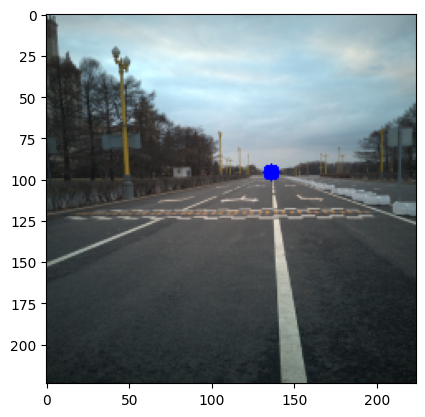

In [11]:
import cv2
# debug datasets 

test_transforms = transforms.Compose([Rescale((224, 224)),
                                      ToTensor(),])
test_set = VanishingPoints(DATA_DIR, 'test', test_transforms)
image = test_set[0][0].permute((1, 2, 0))
image = (image.numpy()*255).astype('uint8')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.circle(image, tuple(test_set[0][1].numpy().astype('int')), radius=5, color=(255, 0, 0), thickness=-1)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB));

In [137]:
# Место для вашего кода